Epoch 1/100 (SGD), Train Loss: 1.5618, Validation Loss: 1.5669
Epoch 2/100 (SGD), Train Loss: 1.0005, Validation Loss: 1.0039
Epoch 3/100 (SGD), Train Loss: 0.7393, Validation Loss: 0.7400
Epoch 4/100 (SGD), Train Loss: 0.6094, Validation Loss: 0.6091
Epoch 5/100 (SGD), Train Loss: 0.5331, Validation Loss: 0.5319
Epoch 6/100 (SGD), Train Loss: 0.4820, Validation Loss: 0.4804
Epoch 7/100 (SGD), Train Loss: 0.4453, Validation Loss: 0.4435
Epoch 8/100 (SGD), Train Loss: 0.4169, Validation Loss: 0.4150
Epoch 9/100 (SGD), Train Loss: 0.3955, Validation Loss: 0.3932
Epoch 10/100 (SGD), Train Loss: 0.3759, Validation Loss: 0.3738
Epoch 11/100 (SGD), Train Loss: 0.3609, Validation Loss: 0.3585
Epoch 12/100 (SGD), Train Loss: 0.3483, Validation Loss: 0.3461
Epoch 13/100 (SGD), Train Loss: 0.3371, Validation Loss: 0.3348
Epoch 14/100 (SGD), Train Loss: 0.3272, Validation Loss: 0.3252
Epoch 15/100 (SGD), Train Loss: 0.3184, Validation Loss: 0.3167
Epoch 16/100 (SGD), Train Loss: 0.3098, Validatio

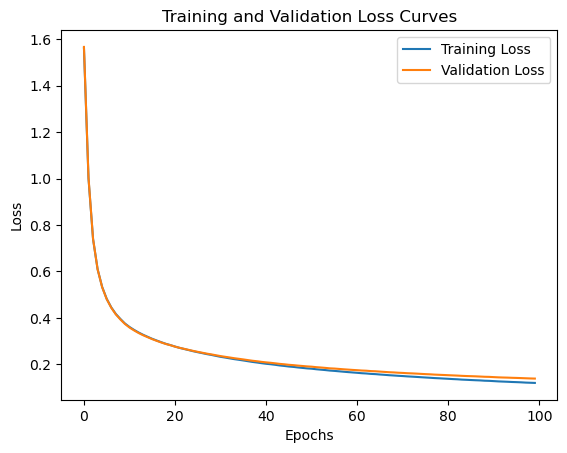

Test Accuracy (MNIST): 94.31%


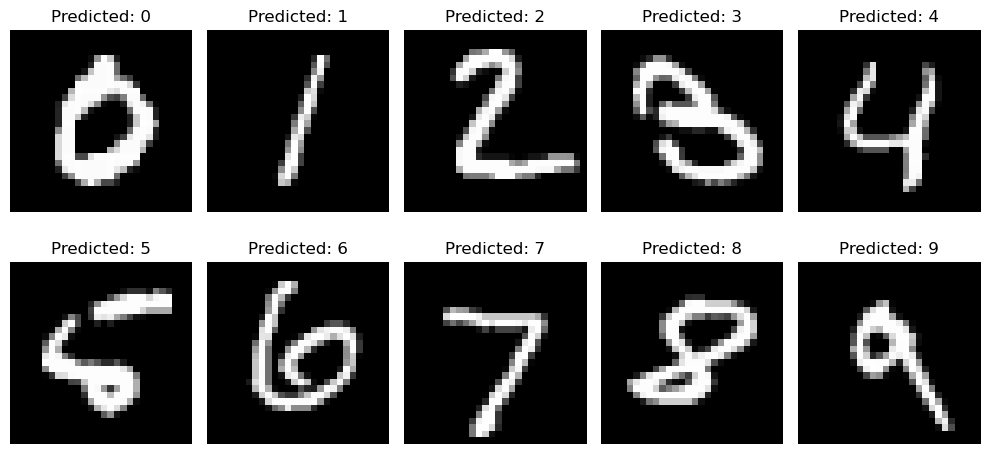

In [106]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import struct
from array import array
from os.path import join

# 1. Load and Prepare MNIST Data
class MnistDataloader:
    def __init__(self, train_img_path, train_lbl_path, test_img_path, test_lbl_path):
        self.train_img_path = train_img_path
        self.train_lbl_path = train_lbl_path
        self.test_img_path = test_img_path
        self.test_lbl_path = test_lbl_path

    def read_images_labels(self, images_filepath, labels_filepath):
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            image_data = array("B", file.read())

        images = np.array(image_data).reshape(size, rows * cols) / 255.0
        labels = np.array(labels)
        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.train_img_path, self.train_lbl_path)
        x_test, y_test = self.read_images_labels(self.test_img_path, self.test_lbl_path)
        return (x_train, y_train), (x_test, y_test)

# File paths
input_path = "c:/Users/pnaghs1/OneDrive - Louisiana State University/github/project1"
train_img_path = join(input_path, "train-images.idx3-ubyte")
train_lbl_path = join(input_path, "train-labels.idx1-ubyte")
test_img_path = join(input_path, "t10k-images.idx3-ubyte")
test_lbl_path = join(input_path, "t10k-labels.idx1-ubyte")

# Load Data
mnist_loader = MnistDataloader(train_img_path, train_lbl_path, test_img_path, test_lbl_path)
(x_train, y_train), (x_test, y_test) = mnist_loader.load_data()

# Split MNIST training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# One-hot encoding function
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_encoded = one_hot_encode(y_train)
y_val_encoded = one_hot_encode(y_val)
y_test_encoded = one_hot_encode(y_test)

# 2. Define Activation Functions
class ActivationFunction:
    def forward(self, x):
        raise NotImplementedError

    def derivative(self, x):
        raise NotImplementedError

class Relu(ActivationFunction):
    def forward(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        return (x > 0).astype(float)

class Softmax(ActivationFunction):
    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Numerical stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def derivative(self, x):
        # Placeholder method, Softmax derivative is handled separately
        return np.ones_like(x)  
    
#softplus , Mish

class Softplus(ActivationFunction):
    def forward(self, x):
        return np.log(1 + np.exp(x))

    def derivative(self, x):
        return 1 / (1 + np.exp(-x))

class Mish(ActivationFunction):
    def forward(self, x):
        return x * np.tanh(np.log(1 + np.exp(x)))

    def derivative(self, x):
        sp = np.log(1 + np.exp(x))
        tanh_sp = np.tanh(sp)
        return tanh_sp + x * (1 - tanh_sp ** 2) * (1 / (1 + np.exp(-x)))


# 3. Define Loss Functions
class CrossEntropy:
    def loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0)
        return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

    def derivative(self, y_true, y_pred):
        return (y_pred - y_true) / y_true.shape[0]  # FIXED GRADIENT SCALING

# 4. Define Layer Class with Dropout
class Layer:
    def __init__(self, fan_in, fan_out, activation_function, dropout_rate=0.0):
        self.weights = np.random.randn(fan_in, fan_out) * np.sqrt(2 / fan_in)  # He Initialization
        self.bias = np.zeros((1, fan_out))
        self.activation = activation_function
        self.dropout_rate = dropout_rate
        self.training = True  # Default: training mode

    def forward(self, x, training=True):
        self.input = x
        self.z = np.dot(x, self.weights) + self.bias
        self.output = self.activation.forward(self.z)

        # dropout

        if training and self.dropout_rate > 0.0:
            self.dropout_mask = np.random.binomial(1, 1 - self.dropout_rate, size=self.output.shape) / (1 - self.dropout_rate)
            self.output *= self.dropout_mask

        return self.output

    def backward(self, delta, learning_rate, rmsprop=False, decay_rate=0.9):
        if self.dropout_rate > 0.0:
            delta *= self.dropout_mask

        activation_derivative = self.activation.derivative(self.z)
        delta *= activation_derivative

        grad_weights = np.dot(self.input.T, delta)
        grad_bias = np.sum(delta, axis=0, keepdims=True)
        
        #RMSPROP

        if rmsprop:
            # RMSProp weight update
            self.cache_weights = decay_rate * self.cache_weights + (1 - decay_rate) * grad_weights**2
            self.cache_bias = decay_rate * self.cache_bias + (1 - decay_rate) * grad_bias**2

            self.weights -= (learning_rate / (np.sqrt(self.cache_weights) + self.epsilon)) * grad_weights
            self.bias -= (learning_rate / (np.sqrt(self.cache_bias) + self.epsilon)) * grad_bias
        else:
            # Vanilla SGD
            self.weights -= learning_rate * grad_weights
            self.bias -= learning_rate * grad_bias

        # Propagate delta to previous layer
        return np.dot(delta, self.weights.T)

# 5. Define Multilayer Perceptron Class
class MultilayerPerceptron:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x, training=True):
        for layer in self.layers:
            x = layer.forward(x, training=training)
        return x

    def backward(self, loss_grad, learning_rate, rmsprop=False):
        for layer in reversed(self.layers):
            loss_grad = layer.backward(loss_grad, learning_rate, rmsprop=rmsprop)

    def train(self, X_train, y_train, X_val, y_val, loss_func, learning_rate=0.01, epochs=100, batch_size=32, rmsprop=False):
        train_losses, val_losses = [], []

        for epoch in range(epochs):
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train, y_train = X_train[indices], y_train[indices]

            # mini batch SGD 

            for start in range(0, X_train.shape[0], batch_size):
                end = start + batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                y_pred = self.forward(X_batch, training=True)
                loss_grad = loss_func.derivative(y_batch, y_pred)
                self.backward(loss_grad, learning_rate, rmsprop=rmsprop)

            train_loss = loss_func.loss(y_train, self.forward(X_train, training=False))
            val_loss = loss_func.loss(y_val, self.forward(X_val, training=False))

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            #

            optimizer_used = "RMSProp" if rmsprop else "SGD"
            print(f"Epoch {epoch + 1}/{epochs} ({optimizer_used}), Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        return train_losses, val_losses
# 6. Define and Train the MLP with Dropout
layers = [
    Layer(fan_in=784, fan_out=128, activation_function=Relu(), dropout_rate=0.2),
    Layer(fan_in=128, fan_out=64, activation_function=Relu(), dropout_rate=0.2),
    Layer(fan_in=64, fan_out=10, activation_function=Softmax(), dropout_rate=0.0),
]

mlp = MultilayerPerceptron(layers)
loss_func = CrossEntropy()
train_losses, val_losses = mlp.train(X_train, y_train_encoded, X_val, y_val_encoded, loss_func, learning_rate=0.001,epochs=100,rmsprop=False)

# 7. Evaluate the Model
for layer in mlp.layers:
    layer.training = False  # Ensure dropout is off

y_pred_test = mlp.forward(x_test)
accuracy = np.mean(np.argmax(y_pred_test, axis=1) == y_test)
print(f"Test Accuracy (MNIST): {accuracy * 100:.2f}%")

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Evaluate on Test Set
y_pred_test_mnist = mlp.forward(x_test)
accuracy = np.mean(np.argmax(y_pred_test, axis=1) == y_test)
print(f"Test Accuracy (MNIST): {accuracy * 100:.2f}%")

# Display a sample from each class
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()
for digit in range(10):
    idx = np.where(y_test == digit)[0][0]
    axs[digit].imshow(x_test[idx].reshape(28, 28), cmap='gray')
    axs[digit].set_title(f'Predicted: {np.argmax(y_pred_test_mnist[idx])}')
    axs[digit].axis('off')
plt.tight_layout()
plt.show()
